# Libraries

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re
import pickle

from wordcloud import WordCloud
#pd.set_option('display.max_colwidth', -1)

After web scrapping we created one single data frame with columns 'price', 'locali', 'superficie', 'bagni', 'piano', 'description' and stored it as a .csv file for future usage. 

In [ ]:
#Importing data into memory from the stored .csv file
data = pd.read_csv("data_houses.csv", sep='\t', encoding='utf-8')
data.columns

In [ ]:
#The number of rows before cleaning
data.shape

In [ ]:
#Checking null values of the dataset
data.isnull().sum()

In [ ]:
#Checking data types of the dataset
data.dtypes

In [ ]:
data.loc[:,['price','locali','superficie','bagni','piano']].describe()

In [ ]:
#The values where the number of bathrooms are 1, 2 or 3 should be kept because they are the most common ones and other numbers 
#are rare and therefore considered outliers(they are probably buildings_?)
#also 3+ is eliminated cause it has ambigious meaning

In [ ]:
#We decided to drop the rows where the value of the floor is 11+ because there aren't many of those rows and they don't show
data.piano.value_counts()
#eliminate R, A, S and 11+  cause it is ambigious



After _analyzing_ the possible values of each attribute of the dataset we decided the following about the process of 
**cleaning** the dataset before making two separate datasets for clustering.
    
The data cleaning process:
    1. Remove nan values
    2. Attribute price should be converted to integer data type and '€' removed from the values
    3. In attribute locali remove rows where the value of locali is 5+ and convert attribute to integer data type
    4. Attribute superficie has some strange values because of the scrapping, like dates '14/02/19' '18/01/19' and all the values that don't make sense should be removed and the attribute should be converted to the integer data type
    5. For attribute piano replace T->0 and drop the rows with piano values A, R, S and 11+ cause they are ambiguous
    
The goal of the cleaning process was to eliminate all the ambiguous values and categorical values that can't have a meaningful numerical representation.

In [ ]:
def clean_data(data):
    """
    Method that removes nan values and cleanes the data
    
    Input: dataframe
    Output: cleaned dataframe
    """
    
    #Remove rows where there aren't all values present
    data.dropna(inplace=True)

    #try to convert price to int and remove € 
    for i in data.index:
    #Becasuse of the web scrapping some prices had strings and text in this way we dealt with it if exception appears
    #'da' is because some prices were scrapped with the word 'da' before the price
        try:
            data.price[i]=int(data.price[i].replace('€', '').strip().replace('.','').replace('da',''))
    #before word class there is price we need
        except:
            try:
                data.price[i]=int(data.price[i].split('class')[0].replace('€', '').strip().replace('.',''))
           #in case of the bad scrapping value (e.g.just text) just drop those rows
            except:
                data.drop(i,inplace=True)
            
    #convert to int superficie and remove / and . in order to convert to int normally
    data.superficie=data.superficie.replace('[/]', '', regex=True).apply(lambda x: int(str(x).replace('.','')))
    
    #Drop rows where values of locali is 5+ and convert to int
    #strip is because of the web scrapping process which took whitespace
    data['locali']=data['locali'].apply(lambda x: x.strip())
    data.drop(data[ data['locali']=='5+'].index,inplace=True)


    #drop A, R, S and 11+  cause it is ambigious 
    data.drop(data[(data['piano']=='A') | (data['piano']=='R') | ( data['piano']=='S')| ( data['piano']=='11+')].index,inplace=True)
    #Attribute piano replace T->0 cause piano T is 'terro' which means it is floor 0
    data['piano']=np.where(data['piano']=='T', 0, data['piano'])     
    
    #remove whitespace from the values
    data.bagni=data.bagni.apply(lambda x: x.strip())
    #remove all the rows where the value of bagni is not 1,2,3...like 3+, cause other values don't have so many value counts
    data.drop(data[( data['bagni']!='1')&( data['bagni']!='2')&( data['bagni']!='3')].index,inplace=True)    

    #convert type of "price","locali","piano", "bagni" to numeric instead of object
    data[["price","locali","piano", "bagni"]] = data[["price","locali","piano", "bagni"]].apply(pd.to_numeric)
    
    #reset index so it starts from 0 to last row number not with scpapped number indices, but with consistent range
    data.reset_index(inplace=True)
    data.drop('index',axis=1,inplace=True)
    
    return data

In [ ]:
cleaned_data=clean_data(data)

In [ ]:
cleaned_data.index

In [ ]:
cleaned_data

In [ ]:
cleaned_data.index

In [ ]:
#The number of rows after cleaning the dataset
#10773
cleaned_data.shape

In [ ]:
#After cleaning the data(dropping rows where there aren't some values) there aren't any NaN values present
cleaned_data.isnull().sum()

In [ ]:
cleaned_data.dtypes

# Datasets

Based on the single data frame we extracted using the web scrapping process we created the Description and the Information datasets

## Description dataset

(Description dataset)

    columns: description 

In [ ]:
description_dataset=pd.DataFrame(cleaned_data.description)
pd.set_option('display.max_colwidth', -1)
description_dataset.head(1)

## Information dataset

(Information dataset)

    columns: price, locali, superficie, bagni, piano

In [ ]:
information_dataset=cleaned_data.drop(['description'],axis=1)
information_dataset.head(5)

In [ ]:
#In this way we can reuse it and not repeat cleaning process every time we execute the notebook

In [ ]:
#Save information and description datasets to two separate .csv files

In [ ]:
information_dataset.to_csv('information_dataset.csv')

In [ ]:
description_dataset.to_csv('description_dataset.csv')

In [ ]:
#Make vocabulary

In [ ]:
def preprocessing_text(df):
    """
    Method that returns filtered words from the text input 
    
    Input: string(text)
    Output: list(bag of words)
    """  
    #remove upper cases
    df=df.lower()
   
    #replacing new line sign '\n' '\r' and 'div' from html with a whitespace ' '    
    df=df.replace('\\n',' ').replace('\\r',' ').replace('div',' ')
    
    #for removing stop words
    stop_words = set(stopwords.words('italian')) 
    stop_words.add('div')
    stop_words.add('n')
    stop_words.add('b')

    #remove numbers
    df = re.sub("\d+", "", df)
    
    #for removing punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    
    #to tokenize the string
    word_tokens = tokenizer.tokenize(df)     

    #stemming
    ps = PorterStemmer()
    filtered_words = [ps.stem(w) for w in word_tokens if not w in stop_words] 

    return filtered_words

In [ ]:
res=description_dataset.description.apply(lambda x: preprocessing_text(x))

In [ ]:
len(res[0])

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
every row is a separate house(which is considered as a separate document)

In [ ]:
res

In [ ]:
pd.Series(res[0]).count()

In [ ]:
len(pd.Series(res[0]))

In [ ]:
pd.Series(res[0]).value_counts()

In [ ]:
pd.Series(description_dataset.description[0]).value_counts()

In [ ]:
description_dataset.a

In [ ]:
vocabulary_set = set(res[1]).union(*res[2:])

In [ ]:
def build_vocabulary(df):
    """
    Method that creates vocabulary
    
    Input: dataframe
    Output: vocabulary list 
    """  
    #list for vocabulary 
    vocabulary_lst=[]
    #preprocessing description and get res->list of lists, where each list i a list of filtered preproccesed words 
    res=df.description.apply(lambda x: preprocessing_text(x))   
    
    #vocabulary_set is a set used for making vocabulary with unique words

    vocabulary_set = set(res[1]).union(*res[2:])

    
    #mapping words into integers
    vocabulary={} 
    for k,v in enumerate(vocabulary_set):
        vocabulary[v]= k
    return res,vocabulary

In [ ]:
res,vocabulary=build_vocabulary(description_dataset)

In [ ]:
len(res[0])

In [ ]:
len(vocabulary)

In [ ]:
#Saving vocabulary as a dictionary into a "vocabulary.p" (pickle) file

#21370 what else should we eliminate from the words??
pickle.dump(vocabulary, open("vocabulary.p", "wb"))

In [ ]:
#To load it into memory from file
vocabulary = pickle.load(open("vocabulary.p", "rb"))

In [ ]:
len(vocabulary)

In [ ]:
####NEED TO change and finish it in ORDER TO CALCULATE TF_IDF VALUES 
def compute_inverted_idx(res,vocabulary):
    """
    method that computes an inverted index
    
    input: res(list of lists), vocabulary(dictionary of all unique words, key=term, value=term_id)
    output: inverted_idx(dictionary, key=term_id, value=list of document_ids(rows)) 
    """
    #initialize defaultdict for making an inverted index
    inverted_idx = defaultdict(list)
    #in every document look for every word and assign document id to the words which belong to it
    for lst in res:
        for word in lst:
            inverted_idx[vocabulary[word]].append(idx)
    return inverted_idx

# Clustering

This step consists in _clustering the house announcements_ using **K-means++** and choosing the **optimal** number of clusters using the **Elbow-Method**.

In [24]:
information_dataset=pd.read_csv('information_dataset.csv')

In [25]:
#should we normalize?

In [26]:
# Information dataset clustering

In [27]:
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Text(0.5,1,'Elbow curve')

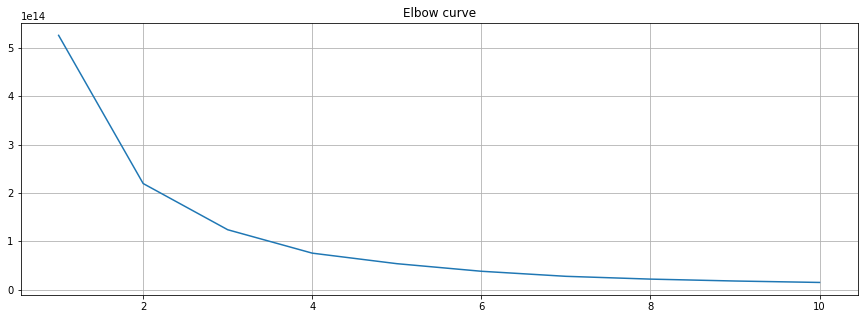

In [35]:
X=information_dataset.loc[:,['price','locali','superficie','bagni','piano']]
distorsions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,init='k-means++')
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), distorsions)
plt.grid(True)
plt.title('Elbow curve')

We chose blabla clusters:
Becausee

In [54]:
k=3
kmeans = KMeans(n_clusters=k,init='k-means++')
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
#centroids are:
kmeans.cluster_centers_

array([[5.12316100e+05, 3.83788774e+00, 1.24613368e+02, 1.84711965e+00,
        2.47525849e+00],
       [1.13150727e+06, 4.28779070e+00, 1.66063953e+02, 2.22093023e+00,
        2.65116279e+00],
       [2.21033802e+05, 2.76065277e+00, 4.62876829e+02, 1.28726849e+00,
        2.03794845e+00]])

In [56]:
information_dataset.columns

Index(['Unnamed: 0', 'price', 'locali', 'superficie', 'bagni', 'piano'], dtype='object')

In [57]:
cluster_representatives=pd.DataFrame(kmeans.cluster_centers_, columns= information_dataset.columns[1:])
cluster_representatives

,price,locali,superficie,bagni,piano
0,5.123161e+05,3.837888,124.613368,1.847120,2.475258
1,1.131507e+06,4.287791,166.063953,2.220930,2.651163
2,2.210338e+05,2.760653,462.876829,1.287268,2.037948


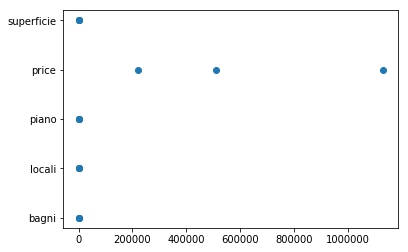

In [58]:
a=cluster_representatives.melt()
b=a.value
b1=a.variable
plt.plot(b,b1,'o')

In [63]:
kmeans.cluster_centers_.shape[0]
labels=kmeans.labels_
centers = np.array(kmeans.cluster_centers_)

In [70]:
centers

array([[5.12316100e+05, 3.83788774e+00, 1.24613368e+02, 1.84711965e+00,
        2.47525849e+00],
       [1.13150727e+06, 4.28779070e+00, 1.66063953e+02, 2.22093023e+00,
        2.65116279e+00],
       [2.21033802e+05, 2.76065277e+00, 4.62876829e+02, 1.28726849e+00,
        2.03794845e+00]])

In [73]:
#price centroids
centers[:,0]

array([ 512316.10044314, 1131507.26744186,  221033.80158011])

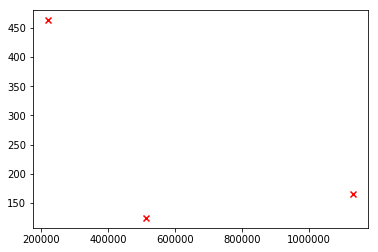

In [78]:
number_of_clusters=kmeans.cluster_centers_.shape[0]

#centroidi klastera


#Centroid's visualization
#for price and superficie
centers = np.array(kmeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,2], marker="x", color='r')

In [ ]:
# Description dataset clustering